In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')
import cv2

import seaborn as sns

## Discriminator

In [147]:
class Conv2Central(nn.Module):
    def __init__(self):
        super().__init__()
        self.kernel  = Variable(torch.tensor([[[[1., 0.5],[0.5, 0.25]]]]))
    
    def forward(self, img):
        N, H, W = img.size()
        img0 = img.unsqueeze(1)
        
        img1 = torch.cat((torch.cat((img0, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img2 = F.conv2d(img1, self.kernel, stride=(1, 1))
        img3 = torch.flip(img2, dims=[0])
        
        img4 = torch.cat((torch.cat((img3, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img5 = F.conv2d(img4, self.kernel, stride=(1, 1))
        img6 = torch.flip(img5, dims=[1])
        
        img7 = torch.cat((torch.cat((img6, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img8 = F.conv2d(img7, self.kernel, stride=(1, 1))
        img9 = torch.flip(img8, dims=[0])
        
        img10 = torch.cat((torch.cat((img9, torch.zeros(N, 1, 1, W)), dim=2), torch.zeros(N, 1, H+1, 1), ), dim=3)
        img11 = F.conv2d(img10, self.kernel, stride=(1, 1))
        img12 = torch.flip(img11, dims=[1])
        
        img13 = img12.squeeze(1)
        return img13

In [2]:
class RoundNoGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.round()
    @staticmethod
    def backward(ctx, g):
        return g

In [3]:
class Num2Point(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.fc1 = nn.Linear(1, n*2)
        self.fc2 = nn.Linear(n*2, n)
        self.fc3 = nn.Linear(n, n)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(-1, 1) # Linear層に入力できるようにサイズを(batch_size, C)にする
        x = self.sigmoid(self.fc1(x)) # write me! # fc1 + sigmoid
        x = self.sigmoid(self.fc2(x)) # write me! # fc2 + sigmoid
        y = self.fc3(x) # write me! # fc3
        return y

In [208]:
class PlotLine(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        self.conv2central = Conv2Central()
        self.num2point = Num2Point(img_size)
        self.num2point.load_state_dict(torch.load('params.pth', map_location=torch.device('cpu') ))
        # freeze all layers
        for param in self.num2point.parameters():
            param.requires_grad = False
        

    def forward(self, points):
        N = points.size()[0] # batch_size
        
        points0 = torch.cat((torch.zeros([N,1,2]),
                            points.repeat([1,1,2]).reshape([N,-1, 2]),
                            torch.zeros([N,1,2])), dim=1).reshape([N, -1, 2, 2])[:, 1:-1]
        #print(points0)
        t = torch.tensor(range(0, self.img_size+1))/self.img_size
        ts = torch.stack((1-t, t)).to(torch.float)
        line = torch.matmul(ts.mT, points0)
        #print(line)
        #line = torch.round(line)
        line0 = RoundNoGradient.apply(line)
        #line0 = line
        #print(line0)
        line1 = line0[:, :, 0:-1].reshape(N, -1, 2)
        #print(line1)
        shape = line1.size()
        line2 = line1.flatten()
#         E = Variable(torch.eye(self.img_size), requires_grad=True) # ここからline４までDNNで作るしかないか？
#         #line = F.embedding(line.to(torch.long), E)
#         line3 = ToLongNoGradient.apply(line2)
#         print(line3)
#         #line3 = line2
#         line4 = F.embedding(line3, E)
        line4 = F.softmax(self.num2point(line2), dim=1)
        #print(line4)
        line5 = line4.reshape(*shape, -1)
        x = line5[:, :, 0, :].unsqueeze(2)
        y = line5[:, :, 1, :].unsqueeze(2)
        p_map = torch.matmul(x.mT, y).sum(dim=1)
        #p_map0 = self.conv2central(p_map)
        p_map0 = torch.tanh(p_map*10)
        return p_map0

tensor([[39., 45.],
        [37., 45.],
        [ 6., 25.],
        [44., 19.],
        [31., 41.]])
tensor(1., grad_fn=<MaxBackward1>)


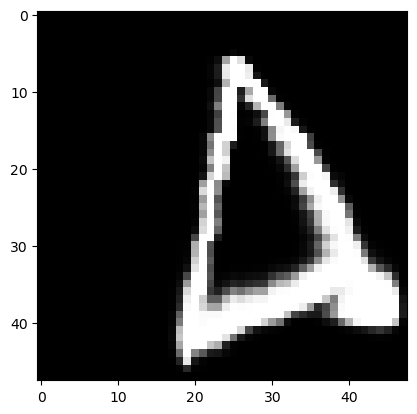

In [209]:
points = torch.randint(0, 48, [5, 2]).to(torch.float)
print(points)

plot_line2 = PlotLine(48)
inputs = Variable(points.unsqueeze(0), requires_grad=True)
canvas = plot_line2(inputs)
print(canvas.max())
plt.imshow(canvas.detach().numpy()[0], cmap="gray")
plt.show()

<AxesSubplot:>

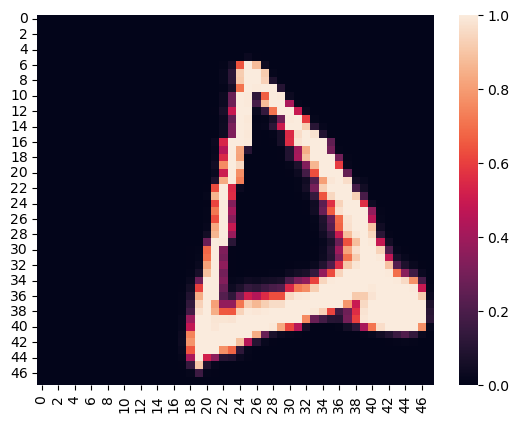

In [210]:
sns.heatmap(canvas.detach().numpy()[0])

In [175]:
def process_img(img):
    img_np = np.array(img)
    img_np = ~img_np
    _, img_th = cv2.threshold(img_np, 0, 255, cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.float32)/9.
    img_blr = cv2.filter2D(img_th.astype(np.float32),-1,kernel)
    img_blr = img_blr.squeeze()
    img_blr = img_blr/img_blr.max()
    img_blr = -img_blr
    img_blr[img_blr>=0] = 100.
    return img_blr.squeeze()

In [176]:
class Discriminator(nn.Module):
    def __init__(self, img):
        super().__init__()
        self.img_size = len(img)
        self.img = torch.from_numpy(process_img(img)).clone()
        
        self.plot_line = PlotLine(self.img_size)
        
    def forward(self, points):
        x = self.plot_line(points)
        #print(x)
        loss = torch.sum(x*self.img)
        return loss

In [177]:
disc = Discriminator(img_array)
points = torch.randint(0, 48, [5, 2]).to(torch.float)
inputs = Variable(points.unsqueeze(0), requires_grad=True)
loss = disc(inputs)
loss

tensor(359567.4375, grad_fn=<SumBackward0>)

## Generator

In [178]:
class Generator(nn.Module):
    def __init__(self, img_size, n_point):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        hidden_size1 = input_size//4
        hidden_size2 = 2*img_size
        output_size = 2*n_point
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=False)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=False)
        self.relu = nn.ReLU()
        
    def forward(self, img):
        x = self.flatten(img)
        #x = x.view(-1, 1) # Linear層に入力できるようにサイズを(batch_size, C)にする. --> x = nn.Flatten(img)
        x = self.relu(self.fc1(x)) # write me! # fc1 + sigmoid
        x = self.relu(self.fc2(x)) # write me! # fc2 + sigmoid
        y = self.fc3(x) # write me! # fc3
        y_num = self.img_size*torch.sigmoid(y)
        out = y_num.reshape(-1, 2, self.n_point)
        return out

In [179]:
i = torch.ones(3,48,48)
flatten = nn.Flatten()
# nn.Flatten(i)
flatten(i).size()

torch.Size([3, 2304])

In [180]:
i = torch.ones(1,48,48)

gen = Generator(n_point=20, img_size=48)
gen(i)

tensor([[[24.4258, 23.8002, 23.8875, 23.3609, 22.8809, 23.0253, 23.6331,
          25.4722, 21.4698, 22.8286, 23.6817, 24.7733, 23.8028, 24.2492,
          24.4155, 22.8000, 24.9667, 22.2649, 23.7762, 25.3657],
         [23.3125, 24.2018, 24.6020, 24.5966, 22.6808, 26.8231, 22.9731,
          21.9740, 25.7727, 24.5345, 22.4541, 21.2163, 24.6241, 24.2046,
          24.0973, 24.2001, 24.3328, 25.0322, 25.4260, 24.3306]]],
       grad_fn=<ReshapeAliasBackward0>)

## ひらがなデータ

[[239 239 240 ... 235 235 236]
 [239 239 240 ... 235 235 236]
 [238 238 240 ... 235 235 236]
 ...
 [241 241 242 ... 241 241 242]
 [241 241 242 ... 241 241 242]
 [241 241 242 ... 241 241 242]]


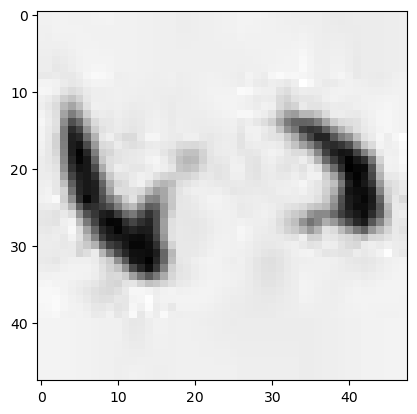

In [3]:
DATADIR = "../data/hiragana73"
CATEGORIES = ["U3042", "U3044", "U3046", "U3048", "U304A"]

category = CATEGORIES[1]
path = os.path.join(DATADIR, category)

image_name = os.listdir(path)[0]
img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
print(img_array)
plt.imshow(img_array, cmap="gray")
plt.show()

<AxesSubplot:>

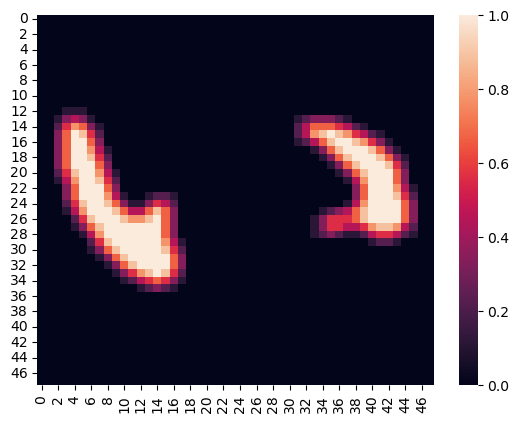

In [4]:
def process_img2(img):
    img_np = np.array(img)
    img_np = ~img_np
    _, img_th = cv2.threshold(img_np, 0, 1, cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.float32)/9.
    img_blr = cv2.filter2D(img_th.astype(np.float32),-1,kernel)
    img_blr = img_blr.squeeze()
#     img_blr = img_blr/img_blr.max()
#     img_blr = -img_blr
#     img_blr[img_blr>=0] = 100.
#     return img_blr.squeeze()
    return img_blr


# img_np = np.array(img_array)
# img_inv = ~img_np
img_p = process_img2(img_array)
sns.heatmap(img_p)

In [158]:
def zscore(x, axis = None):
    x_mean = x.mean(axis=axis, keepdims=True)
    x_std  = np.std(x, axis=axis, keepdims=True)
    z_score = (x-x_mean)/x_std
    return z_score

def make_input(img):
    img = np.array(img)
    img = ~img
    img = zscore(img)
    return torch.from_numpy(img).to(torch.float)

In [159]:
test = make_input(img_array)

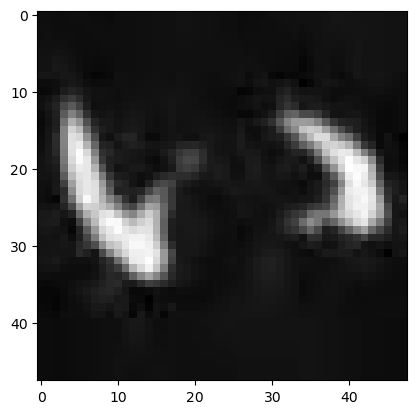

In [160]:
plt.imshow(test, cmap="gray")
plt.show()

In [161]:
# class Sample(nn.Module):
#     def __init__(self, img, n_point):
#         img_size = len(img)
#         self.gen = Generator(img_size, n_point)
#         self.disc = Discriminator(img)
#         self.log = []
    
#     def 

In [162]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using: {device}')

using: cpu


In [163]:
img = img_array
n_point = 10
img_size = len(img)

In [164]:
gen = Generator(img_size, n_point).to(device)
disc = Discriminator(img).to(device)

In [165]:
optimizer = optim.Adam(gen.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [166]:
points_log = []
losses = []

inputs = make_input(img).unsqueeze(0)
inputs = inputs.to(device)

iteration = 20000

gen = gen
disc = disc
gen.train()

for i in range(0, iteration):
    points = gen(inputs)
    points_log.append(points.cpu())
    
    loss = disc(points)
    losses.append(loss.cpu())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if i%1000 == 0:
        print(f'iter: {i}, loss: {loss}')

iter: 0, loss: 1107110.75
iter: 1000, loss: -10673.501953125
iter: 2000, loss: -10655.015625
iter: 3000, loss: -10675.71875
iter: 4000, loss: -10669.8046875
iter: 5000, loss: -10672.75390625
iter: 6000, loss: -10690.201171875
iter: 7000, loss: -10692.9736328125
iter: 8000, loss: -10681.4013671875
iter: 9000, loss: -10683.7568359375
iter: 10000, loss: -10670.3818359375
iter: 11000, loss: -10647.0966796875
iter: 12000, loss: -10691.5205078125
iter: 13000, loss: -10692.1435546875
iter: 14000, loss: -10683.2041015625
iter: 15000, loss: -10624.37890625
iter: 16000, loss: -10662.380859375
iter: 17000, loss: -10672.1845703125
iter: 18000, loss: -10687.84765625
iter: 19000, loss: -10664.076171875


In [174]:
xy = points_log[-1].squeeze_().detach().numpy()
print(xy.shape)
x = xy[0]
y = xy[1]
print(xy)

(2, 10)
[[29.742931 13.478471 29.724895 13.445269 29.648533 13.469175 29.62622
  13.455726 29.620548 13.417423]
 [29.62179  13.478808 29.584759 13.402293 29.563454 13.468567 29.626282
  13.547817 29.695774 13.480463]]


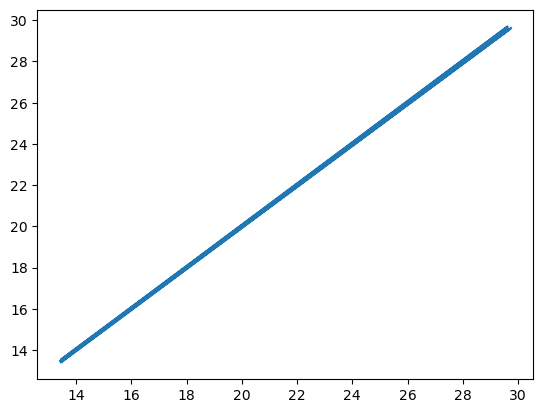

In [170]:
plt.plot(x, y)
plt.show()

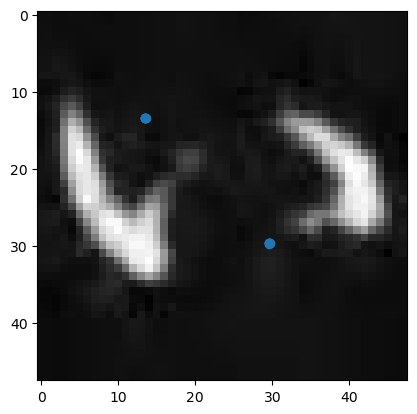

In [173]:
plt.imshow(test, cmap="gray")
plt.scatter(y, x)
plt.show()

In [187]:
a = torch.tensor([[1.,2.],[3.,4.]])
a.mean(dtype=torch.float)

tensor(2.5000)

In [189]:
a/a.max()

tensor([[0.2500, 0.5000],
        [0.7500, 1.0000]])

In [193]:
a = torch.tensor([[0.,10.],[100.,1000.]])
torch.tanh(a)

tensor([[0., 1.],
        [1., 1.]])